# Objective: Define Search bubbles around location (Dhaka) to search for restaurants

In [1]:
# install dependencies
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 25.4 MB/s 
     |████████████████████████████████| 6.3 MB 43.3 MB/s 


### Library Imports

In [2]:
import folium
import geopandas
import numpy as np
import itertools
from shapely.geometry import Point

Taking a random point in dhaka

In [3]:
latitude = 23.7470913
longitude = 90.3700627

# Generate Folium Map
map = folium.Map(location=[latitude, longitude], zoom_start = 14)

## Function for drawing a circle with a certain radius on a folium map:

In [4]:
def draw_circle(map, latitude, longitude, radius):
    folium.vector_layers.Circle(
        location=[latitude, longitude],
        radius=radius,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'        
    ).add_to(map)
    return map

We need to convert Meters into Degree for Latitude/Longitude Calculations  
Rule of thumb: 111,111 meters = 1 degree  
Defining a variable `mtodeg` to convert meters to degreee

In [5]:
mtodeg = 1/111111       # variable mtodeg for converting meters to degree

Horizontal, Vertical Shift between Circles: **225m**  
Radius of Circles: **150m**  
Let's plot 10x10 random circles


In [6]:
map = folium.Map(location=[latitude, longitude], zoom_start = 15)
for jdx in range(10):
    for idx in range(10):
        draw_circle(map, latitude + jdx*mtodeg*225, longitude + idx*mtodeg*225, radius = 150)
map

The Overlap is too much, reducing search efficiency.
A Hexagonal Array would be a more efficient way to search with minimal overlap  
**Hexagonal Overlap:**  
**250m** shifts along each direction  
**150m** shift for every other Circle along the longitude

Let's place 10x10 random circles.

In [7]:
map = folium.Map(location=[latitude, longitude], zoom_start = 15)
for jdx in range(10):
    for idx in range(10):
        lat_new = latitude + jdx*mtodeg*250
        long_new = longitude + idx*mtodeg*250
        if not (jdx%2):
            long_new += mtodeg*150
        draw_circle(map, lat_new, long_new, radius = 150)
map


TODO: A more efficient way to define the points would be with `itertools.product`

## Generate Circles within Boundary of Dhaka

Geometric boundaries are usually defined in GeoJSON files. The GeoJSON file for Dhaka is collected from the following Link: [dhaka.geojson](https://gist.github.com/EmranAhmed/e1f1da00b6677aed023a)  

We first download the data: 




In [8]:
!wget https://gist.githubusercontent.com/EmranAhmed/e1f1da00b6677aed023a/raw/cc9d96ab36289786f491c9cfd537fe01b8121318/dhaka.geojson

--2022-01-25 13:04:12--  https://gist.githubusercontent.com/EmranAhmed/e1f1da00b6677aed023a/raw/cc9d96ab36289786f491c9cfd537fe01b8121318/dhaka.geojson
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20248 (20K) [text/plain]
Saving to: ‘dhaka.geojson’

dhaka.geojson       100%[===================>]  19.77K  --.-KB/s    in 0s      

2022-01-25 13:04:12 (44.9 MB/s) - ‘dhaka.geojson’ saved [20248/20248]



Load the GeoJSON file using **geopandas**

In [9]:
geojson_dhaka = "/content/dhaka.geojson"
geo_dhaka = geopandas.read_file(geojson_dhaka)
geo_dhaka

geometry
0  POLYGON ((90.35088 23.87768, 90.35294 23.87783...

Access the polygon shape for Dhaka

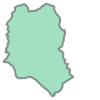

In [10]:
dhaka_polygon = geo_dhaka['geometry'][0]
dhaka_polygon

Polygon bounds

In [11]:
dhaka_polygon.bounds

(90.32890319824219, 23.66103447347277, 90.50880432128906, 23.900591030667897)

### Generate Bubble-Points All over Dhaka

In [12]:
step = 250      # 250m step in each direction
shift = 150     # 150m shift for every other bubble

lng_min, lat_min, lng_max, lat_max = dhaka_polygon.bounds   # get bounds from polygon

Generating points with `itertools.product` within a rectangular bound. 
In order to generate a hexgonal grid, we need to shift the alternate vertical points by 150 meters. This is achieved by taking even/odd latitutes/longitudes separately. 

In [13]:
lats_even = np.arange(start = lat_min, stop = lat_max, step = step*mtodeg)
lats_odd = np.arange(start = lat_min + shift*mtodeg, stop = lat_max, step = step*mtodeg)

lngs_even = np.arange(start = lng_min, stop = lng_max, step = 2*step*mtodeg)
lngs_odd = np.arange(start = lng_min + step*mtodeg, stop = lng_max, step = 2*step*mtodeg)

even_points = itertools.product(lats_even, lngs_even)
odd_points = itertools.product(lats_odd, lngs_odd)

We need to check if the points are within the polygon, otherwise discard

In [14]:
valid_points = []

for point in even_points:
    lat, lng = point
    point = Point(lng, lat)
    if(point.within(dhaka_polygon)): valid_points.append([lat, lng])

for point in odd_points:
    lat, lng = point
    point = Point(lng, lat)
    if(point.within(dhaka_polygon)): valid_points.append([lat, lng])

In [15]:
len(valid_points)

5426

## Function to Generate All Points Inside a Polygon

The above can be put inside a function : 

In [16]:
def get_all_points(polygon, step = 250, shift = 150):
    '''
    This function takes a shapely polygon as an input and returns a list of
    co-ordinates within the polygon
    Args:
    - step: horizontal,vertical step
    - shift: shift for every other point
    '''

    mtodeg = 1/111111       # 1m = 1/111111 deg (approx.)
    lng_min, lat_min, lng_max, lat_max = polygon.bounds


    lats_even = np.arange(start = lat_min, stop = lat_max, step = step*mtodeg)
    lats_odd = np.arange(start = lat_min + shift*mtodeg, stop = lat_max, step = step*mtodeg)

    lngs_even = np.arange(start = lng_min, stop = lng_max, step = 2*step*mtodeg)
    lngs_odd = np.arange(start = lng_min + step*mtodeg, stop = lng_max, step = 2*step*mtodeg)

    even_points = itertools.product(lats_even, lngs_even)
    odd_points = itertools.product(lats_odd, lngs_odd)

    valid_points = []

    for point in even_points:
        lat, lng = point
        point = Point(lng, lat)
        if(point.within(polygon)): valid_points.append([lat, lng])

    for point in odd_points:
        lat, lng = point
        point = Point(lng, lat)
        if(point.within(polygon)): valid_points.append([lat, lng])

    return valid_points


Testing the function

In [17]:
points = get_all_points(dhaka_polygon)

lat = (lat_min + lat_max)/2
lng = (lng_min + lng_max)/2 

map_dhaka = folium.Map(location=[lat, lng], zoom_start = 12)
for lat, lng in points:
    draw_circle(map_dhaka, lat, lng, radius = 150)

map_dhaka

The function is perfectly generating bubbles within the given polygon